## Тема работы:
**Поиск фродовых платежных транзакций.**

Требуется обучить модель машинного обучения классифицировать фродовые транзакции.

Данные предоставлены компанией *Vesta corporation*.

Датасет представляет собой данне банковских транзакций.

Поле TransactionDT - дата совершения транзакции.

Поле TransactionID - ID транзакции.

Поле isFraud :

* 1 - фродовая транзакция
* 0 - лояльная

Остальные поля - фичи

In [94]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from time import time
import datetime
import shap
from scipy.stats import hmean
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
import warnings
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import precision_recall_curve,roc_curve,auc, classification_report,roc_auc_score
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
from plots_report import plot_metrics

### Загрузка данных

In [95]:
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
%matplotlib inline

ссылка на датасет
https://drive.google.com/file/d/1YpbUymYKWslFA5rODD9CTTgSXHbQvRHF/view?usp=sharing

In [96]:
data = pd.read_csv("data/data.csv")

In [98]:
data[data.isFraud == 1].shape

(20663, 303)

In [99]:
data[data.isFraud == 0].shape

(113975, 303)

In [9]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V17,V19,V20,V29,V30,V33,V34,V35,V36,V37,V38,V40,V44,V45,V46,V47,V48,V49,V51,V52,V53,V54,V56,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V143,V145,V146,V147,V149,V150,V151,V152,V154,V156,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V169,V170,V171,V172,V173,V175,V176,V177,V178,V180,V182,V184,V187,V188,V189,V195,V197,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V216,V217,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V231,V233,V234,V238,V239,V242,V243,V244,V245,V246,V247,V249,V251,V253,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V326,V329,V331,V332,V333,V335,V336,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_11,id_12,id_13,id_14,id_15,id_17,id_19,id_20,id_30,id_31,id_32,id_33,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,Transaction_day_of_week,Transaction_hour,id_02__id_20,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_isproton,R_isproton,nulls1,lastest_browser
0,3374591,0,9730691,32.97,W,18249,360.0,150.0,mastercard,126.0,debit,315.0,87.0,12.0,gmail.com,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,11.0,11.0,11.0,11.0,11.0,NaN,NaN,NaN,11.0,11.0,NaN,NaN,NaN,11.0,T,T,NaN,NaN,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,30.95,0.0,30.95,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,30.95,0.0,30.95,0.0,30.95,30.95,30.95,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,968,6.0,14.0,nan_nan,nan_nan,11.0_nan,nan_gmail.com,gmail.com_1.0,360.0_12.0,18249_126.0,360.0_nan,126.0_gmail.com,315.0_18249,446307,450258,517251,449555,False,False,146,0.0
1,3138517,0,3116384,34.50,W,14080,133.0,150.0,visa,226.0,debit,264.0,87.0,19.0,NaN,NaN,10.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0,191.0,NaN,NaN,NaN,254.0,T,T,M0,T,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,39.0,92.00,39.0,29.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,

кодировка категориальных признаков

In [10]:
cat_features = []
for col in tqdm_notebook(data.columns):
    if data[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(data[col].astype(str).values)
        data[col] = le.transform(data[col].astype(str).values)
        cat_features.append(col)

In [11]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V17,V19,V20,V29,V30,V33,V34,V35,V36,V37,V38,V40,V44,V45,V46,V47,V48,V49,V51,V52,V53,V54,V56,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V143,V145,V146,V147,V149,V150,V151,V152,V154,V156,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V169,V170,V171,V172,V173,V175,V176,V177,V178,V180,V182,V184,V187,V188,V189,V195,V197,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V216,V217,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V231,V233,V234,V238,V239,V242,V243,V244,V245,V246,V247,V249,V251,V253,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V326,V329,V331,V332,V333,V335,V336,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_11,id_12,id_13,id_14,id_15,id_17,id_19,id_20,id_30,id_31,id_32,id_33,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,Transaction_day_of_week,Transaction_hour,id_02__id_20,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_isproton,R_isproton,nulls1,lastest_browser
0,3374591,0,9730691,32.97,4,18249,360.0,150.0,2,126.0,2,315.0,87.0,12.0,16,32,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,11.0,11.0,11.0,11.0,11.0,NaN,NaN,NaN,11.0,11.0,NaN,NaN,NaN,11.0,1,1,3,2,1,0,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,30.95,0.0,30.95,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,30.95,0.0,30.95,0.0,30.95,30.95,30.95,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,NaN,NaN,NaN,71,87,NaN,157,2,2,2,2,1120,968,6.0,14.0,37047,36895,14,2421,591,5751,4638,2010,150,11234,446307,450258,517251,449555,False,False,146,0.0
1,3138517,0,3116384,34.50,4,14080,133.0,150.0,4,226.0,2,264.0,87.0,19.0,32,32,10.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0,191.0,NaN,NaN,NaN,254.0,1,1,0,1,0,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,39.0,92.00,39.0,29.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
X = data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = data.sort_values('TransactionDT')['isFraud']

In [13]:
del data
gc.collect()

21

In [14]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V17,V19,V20,V29,V30,V33,V34,V35,V36,V37,V38,V40,V44,V45,V46,V47,V48,V49,V51,V52,V53,V54,V56,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V143,V145,V146,V147,V149,V150,V151,V152,V154,V156,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V169,V170,V171,V172,V173,V175,V176,V177,V178,V180,V182,V184,V187,V188,V189,V195,V197,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V216,V217,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V231,V233,V234,V238,V239,V242,V243,V244,V245,V246,V247,V249,V251,V253,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V326,V329,V331,V332,V333,V335,V336,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_11,id_12,id_13,id_14,id_15,id_17,id_19,id_20,id_30,id_31,id_32,id_33,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,Transaction_day_of_week,Transaction_hour,id_02__id_20,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_isproton,R_isproton,nulls1,lastest_browser
71568,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0000,117.0000,0.0000,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,NaN,NaN,NaN,71,87,NaN,157,2,2,2,2,1120,500,0.0,0.0,37047,36895,36,2437,1805,11414,2199,4214,297,11049,446307,450258,517251,449555,False,False,165,0.0
51299,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,36,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1,1,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,NaN,NaN,NaN,71,87,NaN,157,2,2,

In [15]:
n,_ = X.shape
train_size = int(n*0.8)
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]

In [16]:
del X, y
gc.collect()

0

## Подбор гиперпараметров

Данные емеют временную структуру, поэтому обычное разделение на фолды не подойет.

Используем TimeSeriesSplit

In [19]:
cv = TimeSeriesSplit(n_splits=3)

In [20]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [21]:
def Score_HMean_ROC_PR_AUC(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:,1]

    precision, recall, _ = precision_recall_curve(y, y_pred)
    false_positive_rate, true_positive_rate, _ = roc_curve(y, y_pred)
    
    return(hmean([auc(false_positive_rate, true_positive_rate) - 0.49, auc(recall, precision)]))

bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(objective='binary',verbose=-1, n_estimators=700,max_depth=-1),
    search_spaces = {
        'learning_rate' : Real(0.001, 0.1, 'log-uniform'),
        'num_leaves': Integer(8,256),
        'lambda_l2': Real(0.5, 1000, 'log-uniform')
    },
    n_iter=10,
    scoring = Score_HMean_ROC_PR_AUC,
    verbose = 1,
    n_jobs=-1,
    cv = cv
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)       
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print(f'Model {len(all_models)} \nBest score: {np.round(bayes_cv_tuner.best_score_, 4)} \nBest params: {bayes_cv_tuner.best_params_}\n')

In [22]:
resultLGBM = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)
resultLGBM

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished


Model 1 
Best score: 0.5368 
Best params: OrderedDict([('lambda_l2', 763.7775889051622), ('learning_rate', 0.08601452332433913), ('num_leaves', 128)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


Model 2 
Best score: 0.5368 
Best params: OrderedDict([('lambda_l2', 763.7775889051622), ('learning_rate', 0.08601452332433913), ('num_leaves', 128)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min finished


Model 3 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min finished


Model 4 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.9min finished


Model 5 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


Model 6 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.5min finished


Model 7 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.6min finished


Model 8 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.2min finished


Model 9 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


Model 10 
Best score: 0.5458 
Best params: OrderedDict([('lambda_l2', 18.67885759974523), ('learning_rate', 0.020585058083066172), ('num_leaves', 242)])



BayesSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
              error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=700,
                                       n_jobs=-1, num_leaves=31,
                                       objective='binary', ra...
              refit=True, return_train_score=False,
              scoring=<function Score_HMean_ROC_PR_AUC at 0x000001F96AA816A8>,
              search_spaces={'lambda_l2': Real(low=0.5, high=1000, prior='log-uniform', transform='identity'),
                             'learning_rate': Re

## Кросс валидация

Подбор количества деревьев

In [27]:
params = {
    'lambda_l2': 18.67885759974523,
    'learning_rate': 0.020585058083066172,
    'num_leaves': 242,
    'metric':'auc'
}

In [30]:
folds = TimeSeriesSplit(n_splits=3)
aucs = list()
training_start_time = time()

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 3000, valid_sets = [trn_data, val_data],verbose_eval=300, early_stopping_rounds=150)
    aucs.append(clf.best_score['valid_1']['auc'])
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 150 rounds.
[300]	training's auc: 0.997989	valid_1's auc: 0.885229
Early stopping, best iteration is:
[341]	training's auc: 0.998795	valid_1's auc: 0.885435
Fold 1 finished in 0:00:45.726610
Training on fold 2
Training until validation scores don't improve for 150 rounds.
[300]	training's auc: 0.990409	valid_1's auc: 0.893459
[600]	training's auc: 0.997779	valid_1's auc: 0.894684
Early stopping, best iteration is:
[477]	training's auc: 0.996077	valid_1's auc: 0.895186
Fold 2 finished in 0:01:24.136328
Training on fold 3
Training until validation scores don't improve for 150 rounds.
[300]	training's auc: 0.982173	valid_1's auc: 0.91813
Early stopping, best iteration is:
[281]	training's auc: 0.980666	valid_1's auc: 0.918197
Fold 3 finished in 0:01:14.414575
------------------------------
Training has finished.
Total training time is 0:03:24.284509
Mean AUC: 0.8996062223804695
------------------------------


In [66]:
best_iter = 281

### Резуьтаты на тестовой выборке

In [67]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train, y_train)
pr_prob = clf.predict_proba(X_test)[:, 1]

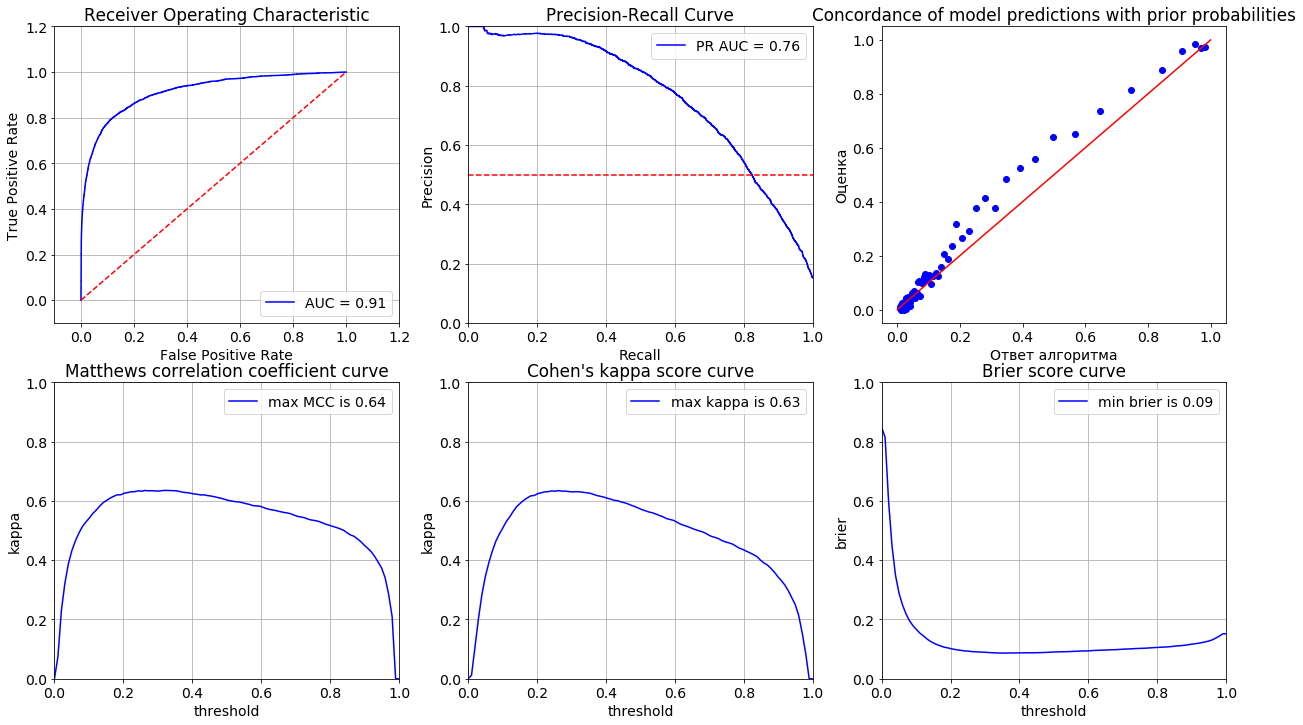

The rmse of model's prediction is: 0.2596
The Gini of model's prediction is: 0.8291
The ROC AUC of model's prediction is: 0.9146
The PR AUC of model's prediction is: 0.7642
Max Cohen's kappa is 0.635 with threshold = 0.26
Max Matthews correlation coefficient is 0.635 with threshold = 0.32
Min Brier score is 0.087 with threshold = 0.35


In [87]:
plot_metrics(y_test.values, pr_prob,n=99)

In [88]:
threshold = 0.26
print(classification_report(y_test, (pr_prob > threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     22840
           1       0.71      0.67      0.69      4088

    accuracy                           0.91     26928
   macro avg       0.82      0.81      0.82     26928
weighted avg       0.91      0.91      0.91     26928



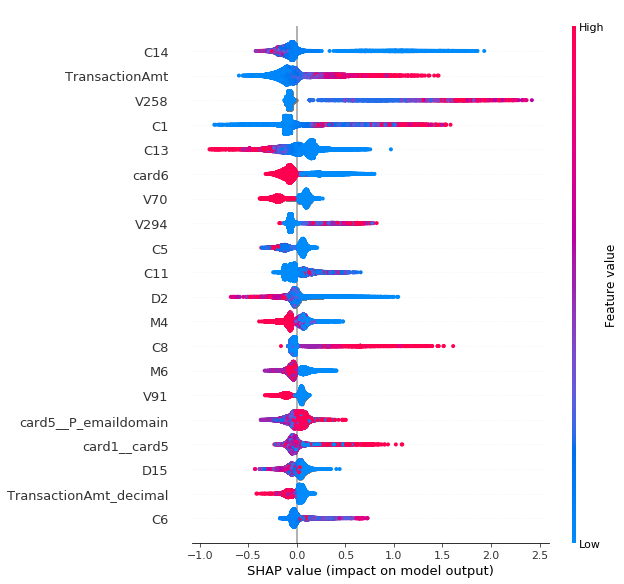

In [70]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)